<a href="https://colab.research.google.com/github/junsoo321/Yongan/blob/main/%EC%84%B1%EB%8A%A5%ED%8F%89%EA%B0%80_%EC%B5%9C%EC%A2%852_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install dlib
!sudo apt-get update
!sudo apt-get install -y cmake
!pip install dlib

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [917 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [51.5 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,389 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,439 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [2,512 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,

In [ ]:
# Install face_recognition
!pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=dfc34d3792637bf3f7111b1cded672eb9896d8929f79e66cd9251ab782e34b79
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [ ]:
# Install other necessary libraries
!pip install numpy scikit-learn Pillow seaborn

In [ ]:
# 패키지 설치 확인
import dlib
import face_recognition
import numpy as np
from sklearn import neighbors
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
from PIL import Image
from face_recognition.face_recognition_cli import image_files_in_folder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Navigate to your dataset directory
data_dir = '/content/drive/MyDrive/data/linearAlgebra2_face_detection_dataset_final'

Mounted at /content/drive


In [ ]:
import math
from sklearn import neighbors
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
import pickle
from PIL import Image
import face_recognition
from face_recognition.face_recognition_cli import image_files_in_folder
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Helper function to get image file paths
def image_files_in_folder(folder):
    return [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.jpg')]

In [ ]:
# 이미지 데이터 증강 객체 생성
datagen = ImageDataGenerator(
    rotation_range=20,  # 회전 범위 (degree)
    width_shift_range=0.2,  # 가로 이동 범위 (전체 가로의 20%)
    height_shift_range=0.2,  # 세로 이동 범위 (전체 세로의 20%)
    shear_range=0.2,  # 전단 변환 범위
    zoom_range=0.2,  # 확대/축소 범위
    horizontal_flip=True,  # 가로 반전 여부
    fill_mode='nearest'  # 이동 시 빈 공간 채우기 방식
 )

In [ ]:
# Process images to get face encodings
def process_images(image_paths, class_label):
    X = []
    y = []

    for img_path in image_paths:
        image = face_recognition.load_image_file(img_path)
        face_bounding_boxes = face_recognition.face_locations(image)

        if len(face_bounding_boxes) == 1:
            face_encoding = face_recognition.face_encodings(image, known_face_locations=face_bounding_boxes)[0]
            X.append(face_encoding)
            y.append(class_label)

            # 데이터 증강
            aug_iter = datagen.flow(np.expand_dims(image, 0), batch_size=1)
            for i in range(4): # 원본 이미지 + 증강 이미지 4개 추가
                aug_img = next(aug_iter)[0].astype('uint8')
                aug_face_encoding = face_recognition.face_encodings(aug_img, known_face_locations=face_bounding_boxes)[0]
                X.append(aug_face_encoding)
                y.append(class_label)

    print(f"{class_label}'s augmentation data : {len(X)}")

    return X, y

In [ ]:
# Split data while maintaining class distribution
def split_and_process_data(data_dir, test_size=0.3):
    X_train, X_test = [], []
    y_train, y_test = [], []

    for team_dir in os.listdir(data_dir):
        team_path = os.path.join(data_dir, team_dir)
        if not os.path.isdir(team_path):
            continue

        for class_dir in os.listdir(team_path):
            class_path = os.path.join(team_path, class_dir)
            if not os.path.isdir(class_path):
                continue

            # Get all image paths
            image_paths = image_files_in_folder(class_path)
            if len(image_paths) == 0:
                continue

            # Create class label
            class_label = f"{team_dir}_{class_dir}"

            # Process images to get face encodings
            X_class, y_class = process_images(image_paths, class_label)

            # Split the class data into train and test sets
            split_index = int(len(X_class) * (1 - test_size))
            X_train.extend(X_class[:split_index])
            y_train.extend(y_class[:split_index])
            X_test.extend(X_class[split_index:])
            y_test.extend(y_class[split_index:])


    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [ ]:
# Class to train KNN model
class TrainFaceData:
    def __init__(self, n_neighbors=None, knn_algo='ball_tree', verbose=False):
        self.n_neighbors = n_neighbors
        self.knn_algo = knn_algo
        self.verbose = verbose
        self.knn_clf = None

    def train(self, X_train, y_train):
        if self.n_neighbors is None:
            self.n_neighbors = int(round(math.sqrt(len(X_train))))
            if self.verbose:
                print("Automatically chosen n_neighbors:", self.n_neighbors)

        self.knn_clf = neighbors.KNeighborsClassifier(n_neighbors=self.n_neighbors, algorithm=self.knn_algo)
        self.knn_clf.fit(X_train, y_train)

    def predict(self, X_test):
        if not self.knn_clf:
            raise ValueError("Model not trained yet.")
        return self.knn_clf.predict(X_test)

    def save_model(self, file_path):
        if not self.knn_clf:
            raise ValueError("Model not trained yet.")
        with open(file_path, 'wb') as f:
            pickle.dump(self.knn_clf, f)
        if self.verbose:
            print(f"Model saved to {file_path}")

    def load_model(self, file_path):
        with open(file_path, 'rb') as f:
            self.knn_clf = pickle.load(f)
        if self.verbose:
            print(f"Model loaded from {file_path}")

In [ ]:
# Paths to data directory and model file
data_dir = '/content/drive/MyDrive/data/linearAlgebra2_face_detection_dataset_final'
model_path = '/content/drive/MyDrive/knn_face_recognition_model_final_data_augmentation.pkl'

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = split_and_process_data(data_dir)

team4_002_KYW's augmentation data : 465
team4_003_LGE's augmentation data : 495
team4_004_SHS's augmentation data : 470
team4_001_KRE's augmentation data : 465
team2_005_KUS's augmentation data : 230
team2_003_KMS's augmentation data : 455
team2_002_KMG's augmentation data : 500
team2_001_PJS's augmentation data : 500
team2_004_LJH's augmentation data : 500
team3_003_KKJ's augmentation data : 410
team3_002_KMJ's augmentation data : 500
team3_004_KMS's augmentation data : 415
team3_001_KHY's augmentation data : 475
team6_003_LDW's augmentation data : 500
team6_001_LSC's augmentation data : 175
team6_004_YSB's augmentation data : 490
team6_002_RYJ's augmentation data : 420
team5_004_PSG's augmentation data : 490
team5_002_JUH's augmentation data : 490
team5_003_MJY's augmentation data : 500
team5_001_CJY's augmentation data : 500
team7_005_YYS's augmentation data : 460
team7_002_JHS's augmentation data : 355
team7_003_KMJ's augmentation data : 485
team7_001_CYW's augmentation data : 445


In [ ]:
# Print the number of data points
print(f"Total data points: {len(X_train) + len(X_test)}")
print(f"Training data points: {len(X_train)}")
print(f"Testing data points: {len(X_test)}")

Total data points: 14085
Training data points: 9854
Testing data points: 4231


In [ ]:
# Train and save the model
trainer = TrainFaceData(verbose=True)
trainer.train(X_train, y_train)
trainer.save_model(model_path)

Automatically chosen n_neighbors: 99
Model saved to /content/drive/MyDrive/knn_face_recognition_model_final_data_augmentation.pkl


In [ ]:
# Load and evaluate the model
trainer.load_model(model_path)
y_pred = trainer.predict(X_test)

Model loaded from /content/drive/MyDrive/knn_face_recognition_model_final_data_augmentation.pkl


In [ ]:
# Evaluate the model 1
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.5658236823445993


In [ ]:
# Evaluate the model 2
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Classification Report:
               precision    recall  f1-score   support

team1_001_PIW       0.60      0.67      0.64       152
team1_002_KHH       0.55      0.57      0.56       150
team1_003_CSB       0.52      0.82      0.64       150
team1_004_KDM       0.57      0.44      0.50       144
team1_005_LSE       0.61      0.47      0.53       150
team2_001_PJS       0.71      0.73      0.72       150
team2_002_KMG       0.18      0.81      0.30       150
team2_003_KMS       0.56      0.68      0.62       137
team2_004_LJH       0.79      0.71      0.75       150
team2_005_KUS       0.87      0.19      0.31        69
team3_001_KHY       0.58      0.61      0.59       143
team3_002_KMJ       0.78      0.77      0.78       150
team3_003_KKJ       0.69      0.34      0.46       123
team3_004_KMS       0.75      0.43      0.55       125
team4_001_KRE       0.80      0.63      0.70       140
team4_002_KYW       0.74      0.43      0.54       140
team4_003_LGE       0.49      0.42      0

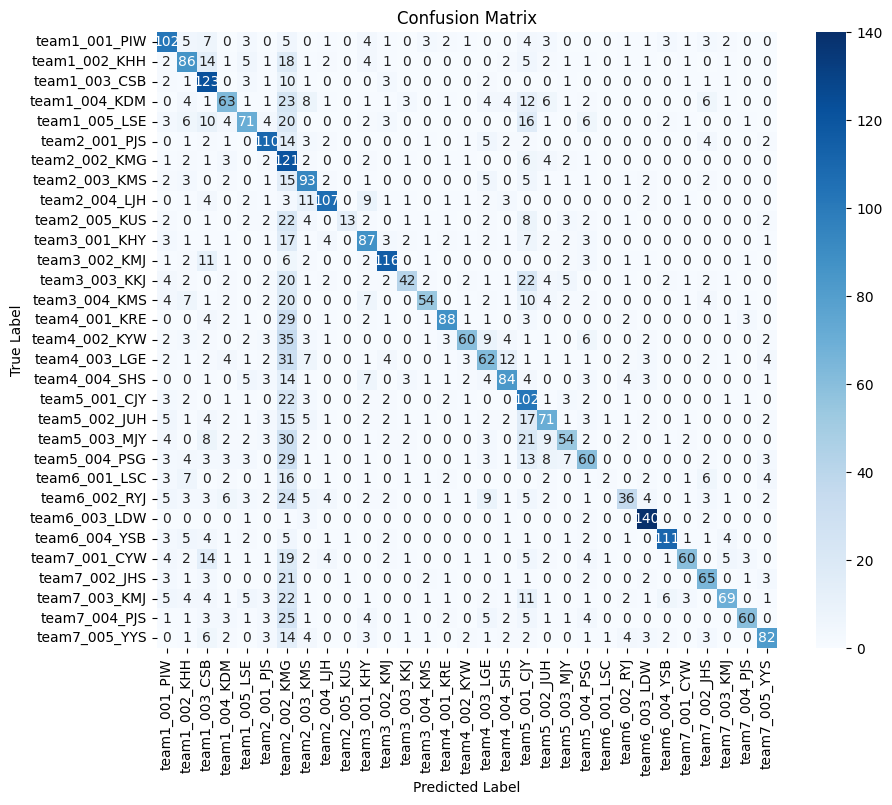

In [ ]:
# Evaluate the model 3
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

team1의 수정된 데이터로 다시 모델 성능 평가를 하였습니다.

먼저 데이터 증진 모델은 Accuracy: 0.5488833746898263 -> Accuracy: 0.5658236823445993 으로 정확도가 상승하였습니다.

confusion matrix를 살펴봤을 때, team1_004_KDM의 true positive가 늘어난 것을 확인할 수 있고 이것 때문에 전체적인 정확도는 늘어난 것 같습니다.

최종2 평가의 confusion matrix에서 team6_001_LSC의 true positive가 이전보다 떨어진 것을 확인했습니다. (11 -> 2)

team6_001_LSC 클래스의 데이터 증진 후 샘플의 개수는 175개로 가장 작은 샘플 수를 가지고 있으므로 이와 같은 결과가 나왔고 모델이 다르게 학습되었다는 것을 확인할 수 있습니다.


team6_003_LDW, team1_001_PIW, team2_004_LJH, team6_004_YSB 클래스가 다른 클래스에 비해 team2_002_KMG 클래스로 예측되는 현상이 보이지 않았는데. 각 클래스의 이미지를 살펴봐도 이 샘플이 어떤 특징을 가져서 모델이 이렇게 학습되었는지는 잘 모르겠습니다.